# Improvement in classification, based on feature selection
Using the information about the top
correlating features obtained in item (4), transform the full data set **`train_smpl`** so as to keep the
following attributes:
* Using only the top 5 pixels from each **`train_smpl_\<label>`**.
* Using only the top 10 pixels from each **`train_smpl_\<label>`**.
* Using only the top 20 pixels from each **`train_smpl_\<label>`**.
* You will have three data sets, with approximately 50, 100 and 200 features (pixels) each.
Repeat the experiment described in item (3) on these three data sets.

In [1]:
import numpy as np
from IPython.utils import io

In [2]:
from Scripts import pixelFinder as pf 
from Scripts.NaiveBayse import NaiveBayseGaussian as nbg
from Scripts import helperfn as hf
from Scripts import plotScripts as ps
%load_ext autoreload
%autoreload 2


In [3]:
def get_top_pixels(n):
    pixel_order = []
    for i in range(-1, 10):
        pixel_order.append(np.array(pf.bestPixels(i, n)))
    return pixel_order

def grab_n_pixels(pixel_order, n):
    output = []

    # j is the pixel order list
    for j in range(len(pixel_order)):
        output.append(pixel_order[j][:n]) 

    return output


def data_lists():
    data = []
    for i in range(-1, 10):
        data.append(helperfn.get_data(i))
    return data

def build_classifiers(data, y_labels, pixel_order, balance_classes=False):
    classifiers = []
    scores = []
    dataset = []
    for i in range(0, len(y_labels)):
        X = np.take(data, pixel_order[i], axis=1)
        y = y_labels[i]
        classifier, score, local_data = nbg.nbg_model_custom_data(X, y, data_label=i-1, balance_classes=balance_classes)
        classifiers += [classifier]
        scores += [score]
        dataset += [local_data]

    return classifiers, scores, dataset


def get_labels():
    labels = []
    for i in range(-1, 10):
        labels.append(hf.get_results(i))
    
    return labels

def run_classifier(x_data, y, pixel_order, n_pixels=5, verbose=False):
    scores_list = []
    classifiers_list = []
    data_list = []

    pixels = grab_n_pixels(pixel_order, 0)

    for i in range(1, n_pixels + 1):
        pixels = grab_n_pixels(pixel_order, i)
        print(len(pixels))
        if not verbose:
            print(i)
            with io.capture_output() as captured:
                classifier, scores, data = build_classifiers(x_data, y, pixels,  balance_classes=True)
        else:
            classifier,  scores, data = build_classifiers(x_data, y, pixels, balance_classes=True)
        
        scores_list.append(scores)
        data_list.append(data)
        classifiers_list.append(classifier)
    
    return scores_list, data_list, classifiers_list


def unzip_all_scores(scores_list):

    train_scores = []
    test_scores = []

    # loops over pixels
    for i in range(len(scores_list)):
        train, test = ps.unzip_scores(scores_list[i])
        train_scores.append(train)
        test_scores.append(test)
    
    return train_scores, test_scores





In [83]:
pixel_order = get_top_pixels(50)

In [153]:
labels = get_labels()
x_data = hf.get_data_noresults()

11
1
11
2
11
3
11
4
11
5
11
6
11
7
11
8
11
9
11
10
11
11
11
12
11
13
11
14
11
15
11
16
11
17
11
18
11
19
11
20
11
21
11
22
11
23
11
24
11
25
11
26
11
27
11
28
11
29
11
30
11
31
11
32
11
33
11
34
11
35
11
36
11
37
11
38
11
39
11
40
11
41
11
42
11
43
11
44
11
45
11
46
11
47
11
48
11
49
11
50


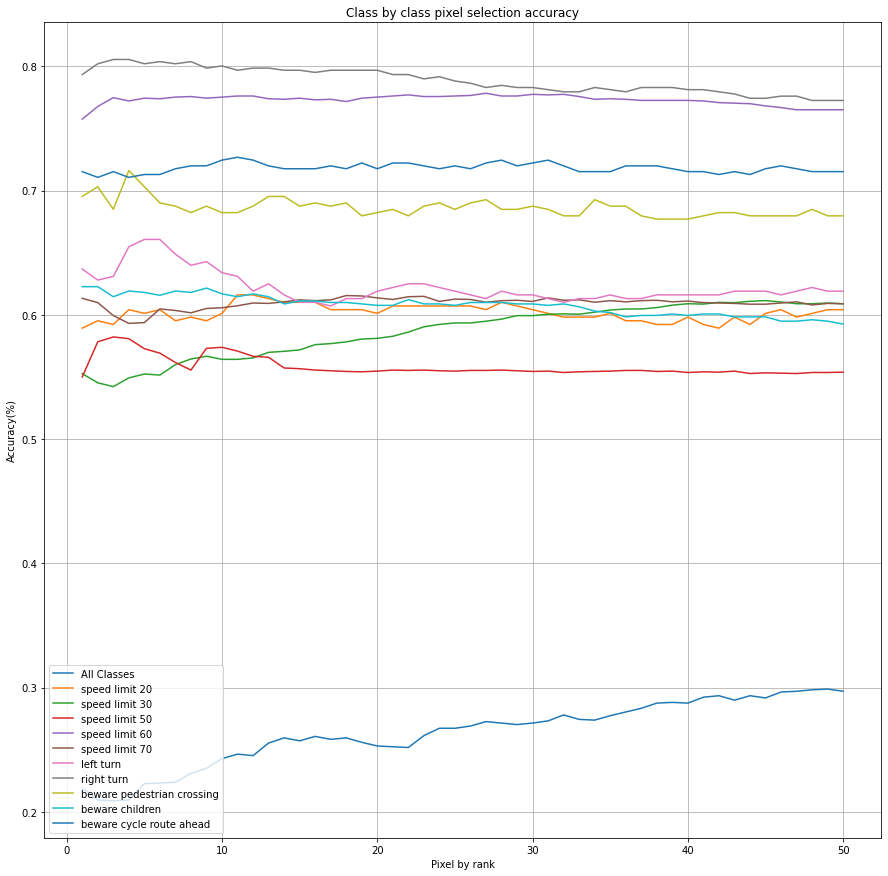

In [84]:
#pixel_order = get_top_pixels(10)



scores_list, data_list, classifiers_list = run_classifier(x_data, labels, pixel_order, n_pixels = 50)

train_scores , test_scores = unzip_all_scores(scores_list)

ps.plot_line_graph(np.array(train_scores))





### Print line chart

In [172]:
working = np.array(test_scores)
print(working)

max_value = []

working = working.T


for i in range(working.shape[0]):
    max_value.append(np.argmax(working[i]))


print(max_value)



    







[[0.22380952 0.58333333 0.54842342 0.53777778 0.80141844 0.60984848
  0.67857143 0.8125     0.72916667 0.60185185 0.63888889]
 [0.20238095 0.61904762 0.52477477 0.55333333 0.81205674 0.61994949
  0.70238095 0.80555556 0.73958333 0.59722222 0.66666667]
 [0.1952381  0.61904762 0.53490991 0.56222222 0.81914894 0.60353535
  0.71428571 0.80555556 0.71875    0.59722222 0.67592593]
 [0.18809524 0.61904762 0.53040541 0.55444444 0.81914894 0.5959596
  0.70238095 0.80555556 0.70833333 0.60648148 0.66666667]
 [0.19285714 0.61904762 0.54842342 0.55555556 0.82092199 0.60353535
  0.72619048 0.80555556 0.69791667 0.59259259 0.67592593]
 [0.2047619  0.61904762 0.55630631 0.54444444 0.81560284 0.61237374
  0.73809524 0.8125     0.69791667 0.60648148 0.67592593]
 [0.2        0.61904762 0.55855856 0.53555556 0.81914894 0.60606061
  0.73809524 0.81944444 0.71875    0.60185185 0.67592593]
 [0.21904762 0.60714286 0.56081081 0.53333333 0.82269504 0.60353535
  0.75       0.80555556 0.70833333 0.60648148 0.685

In [156]:
for i in range(4):
    print(working[0][i])


0.22380952380952382
0.20238095238095238
0.19523809523809524
0.1880952380952381


In [157]:
working[6]

array([0.67857143, 0.70238095, 0.71428571, 0.70238095, 0.72619048,
       0.73809524, 0.73809524, 0.75      , 0.73809524, 0.75      ,
       0.73809524, 0.73809524, 0.73809524, 0.73809524, 0.73809524,
       0.72619048, 0.71428571, 0.70238095, 0.70238095, 0.71428571,
       0.70238095, 0.70238095, 0.70238095, 0.70238095, 0.70238095,
       0.70238095, 0.70238095, 0.70238095, 0.70238095, 0.70238095,
       0.70238095, 0.70238095, 0.70238095, 0.70238095, 0.70238095,
       0.70238095, 0.70238095, 0.70238095, 0.70238095, 0.70238095,
       0.70238095, 0.70238095, 0.69047619, 0.69047619, 0.69047619,
       0.69047619, 0.69047619, 0.69047619, 0.69047619, 0.69047619])

In [200]:
np.argmax(working[6])

7

In [186]:


classifiers_5_pixels, scores_5_pixels, dataset_5_pixels = build_classifiers(x_data, labels, grab_n_pixels(pixel_order, 5))
classifiers_10_pixels, scores_10_pixels, dataset_10_pixels = build_classifiers(x_data, labels, grab_n_pixels(pixel_order, 10))
classifiers_20_pixels, scores_20_pixels, dataset_20_pixels = build_classifiers(x_data, labels, grab_n_pixels(pixel_order, 20))
# classifiers_our_pixels, scores_our_pixels, dataset_our_pixels = build_classifiers(x_data, labels, grab_n_pixels(pixel_order, 49))




Scores for dataset:  All Classes
Training data score:  0.266124871001032
Testing data score:  0.25593395252837975
--------------------------------------
Scores for dataset:  speed limit 20
Training data score:  0.9784571723426213
Testing data score:  0.97781217750258
--------------------------------------
Scores for dataset:  speed limit 30
Training data score:  0.7672858617131063
Testing data score:  0.7853457172342622
--------------------------------------
Scores for dataset:  speed limit 50
Training data score:  0.7225232198142415
Testing data score:  0.7363261093911249
--------------------------------------
Scores for dataset:  speed limit 60
Training data score:  0.7145252837977296
Testing data score:  0.7254901960784313
--------------------------------------
Scores for dataset:  speed limit 70
Training data score:  0.7085913312693498
Testing data score:  0.7063983488132095
--------------------------------------
Scores for dataset:  left turn
Training data score:  0.73065015479876

In [190]:
train_score_5_pixels , test_score_5_pixels = ps.unzip_scores(scores_5_pixels)
train_score_10_pixels , test_score_10_pixels = ps.unzip_scores(scores_10_pixels)
train_score_20_pixels , test_score_20_pixels = ps.unzip_scores(scores_20_pixels)
train_score_our_pixels , test_score_our_pixels = ps.unzip_scores(scores_our_pixels)

new_train_score_5_pixels = []
new_train_scores_10_pixels = []
new_train_score_20_pixels = []
new_train_score_our_pixels = []

for i in range(11):
    new_train_score_5_pixels.append(round(train_score_5_pixels[i], 2) * 100)

for i in range(len(train_score_10_pixels)):
    new_train_scores_10_pixels.append(round(train_score_10_pixels[i], 2) * 100)

for i in range(len(train_score_20_pixels)):
    new_train_score_20_pixels.append(round(train_score_20_pixels[i], 2) * 100)

for i in range(len(train_score_our_pixels)):
    new_train_score_our_pixels.append(round(train_score_our_pixels[i], 2) * 100)

#data_to_print = [new_train_score_5_pixels, new_train_scores_10_pixels, new_train_score_20_pixels, new_train_score_our_pixels]
#data_to_print = [new_train_score_5_pixels, new_train_scores_10_pixels]



In [183]:
classifier_pixels, scores_pixels, dataset_pixels  = build_classifiers(x_data, labels, grab_n_pixels(pixel_order, 5))

Scores for dataset:  All Classes
Training data score:  0.266124871001032
Testing data score:  0.25593395252837975
--------------------------------------
Scores for dataset:  speed limit 20
Training data score:  0.9784571723426213
Testing data score:  0.97781217750258
--------------------------------------
Scores for dataset:  speed limit 30
Training data score:  0.7672858617131063
Testing data score:  0.7853457172342622
--------------------------------------
Scores for dataset:  speed limit 50
Training data score:  0.7225232198142415
Testing data score:  0.7363261093911249
--------------------------------------
Scores for dataset:  speed limit 60
Training data score:  0.7145252837977296
Testing data score:  0.7254901960784313
--------------------------------------
Scores for dataset:  speed limit 70
Training data score:  0.7085913312693498
Testing data score:  0.7063983488132095
--------------------------------------
Scores for dataset:  left turn
Training data score:  0.73065015479876

In [189]:
print(new_train_score_5_pixels)
print(new_train_scores_10_pixels)
print(new_train_score_20_pixels)
print(new_train_score_our_pixels)

print(len(new_train_score_5_pixels))
print(len(new_train_scores_10_pixels))
print(len(new_train_score_20_pixels))
print(len(new_train_score_our_pixels))



data_to_print = [new_train_score_5_pixels, new_train_scores_10_pixels, new_train_score_20_pixels, new_train_score_our_pixels]

print(np.array(data_to_print))



[27.0, 98.0, 77.0, 72.0, 71.0, 71.0, 73.0, 72.0, 68.0, 61.0, 64.0]
[25.0, 67.0, 60.0, 49.0, 70.0, 61.0, 56.99999999999999, 70.0, 59.0, 51.0, 59.0]
[22.0, 52.0, 56.00000000000001, 41.0, 69.0, 55.00000000000001, 53.0, 68.0, 55.00000000000001, 47.0, 54.0]
[24.0, 52.0, 56.99999999999999, 40.0, 68.0, 51.0, 50.0, 66.0, 52.0, 44.0, 52.0]
11
11
11
11
[[27. 98. 77. 72. 71. 71. 73. 72. 68. 61. 64.]
 [25. 67. 60. 49. 70. 61. 57. 70. 59. 51. 59.]
 [22. 52. 56. 41. 69. 55. 53. 68. 55. 47. 54.]
 [24. 52. 57. 40. 68. 51. 50. 66. 52. 44. 52.]]


In [166]:
len(data_to_print)

4

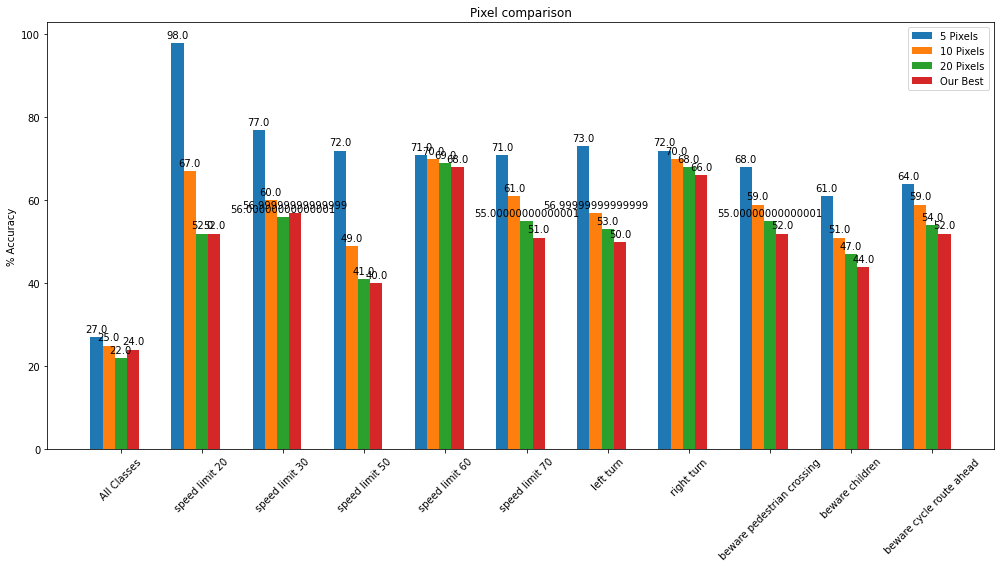

In [191]:
ps.plot_scores(data_to_print, ['5 Pixels','10 Pixels','20 Pixels','Our Best'], title='Pixel comparison')
